# Todo


* Extend A accross either whole amplifier or entire IFU
* still work with single fiber for B



In [26]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [27]:
import numpy as np

from astropy.io import fits
from astropy.stats import biweight_location
from sklearn.decomposition import PCA
import pickle
from matplotlib import pyplot as plt
% matplotlib inline

from collections import OrderedDict
import spectrum
import glob

In [33]:
def load_skys(ff):
    skys = OrderedDict()
    shotids = []
    for f in ff:
        shotid = f.split("/")[2]
        exp = f.split("/")[3]
        ww,rb = pickle.load( open(f,'rb'), encoding='iso-8859-1' )
        skys[(shotid,exp)] = rb["sky_spectrum"]/rb["fiber_to_fiber"] 
    print("starting wl = ", ww[0], "A")
    return ww, skys

In [66]:
def load_skys(ff, which="sky_spectrum", normalize=False):
    """
    Loads bunch of spectra (2D) from set of input file names.
    """
    skys = OrderedDict()
    shotids = OrderedDict()
    N = len(ff)
    sff = []
    for i,f in enumerate(ff):
        if i % 100 == 0:
            print("loading {} out of {}.".format(i,N))
        shotid = f.split("/")[2]
        exp = f.split("/")[3]
        try:
            ww,rb = pickle.load( open(f,'rb'), encoding='iso-8859-1' )
            skys[(shotid,exp)] = rb[which]/rb["fiber_to_fiber"] 
            shotids[(shotid,exp)] = f
        except:
            print("Error loading {}.".format(f))
            pass
        
        if normalize:
            # NEW try to normalize by mean
            skys[(shotid,exp)][np.isnan(skys[(shotid,exp)])] = 0.
            skys[(shotid,exp)] = (skys[(shotid,exp)].T /np.mean( skys[(shotid,exp)], axis=1 )).T
    print("start wl = ", ww[0], "A", "end wl = ", ww[-1], "A")
    return ww, skys, sff

In [ ]:
#N = 100
IFU = "032" # here we select, which IFU we use as basis for the sky model

# how many PCS components do we want to maintain?
n_components = 24

ff_LL=glob.glob ("pca_test/rebin/20??????v???/exp0?/multi_???_{}_???_LL_rebin.pickle".format(IFU))
ff_LU=glob.glob ("pca_test/rebin/20??????v???/exp0?/multi_???_{}_???_LU_rebin.pickle".format(IFU))
ff_RL=glob.glob ("pca_test/rebin/20??????v???/exp0?/multi_???_{}_???_RL_rebin.pickle".format(IFU))
ff_RU=glob.glob ("pca_test/rebin/20??????v???/exp0?/multi_???_{}_???_RU_rebin.pickle".format(IFU))

skys = OrderedDict()
ww,skys[(IFU,"LL")] = load_skys(ff_LL)
ww,skys[(IFU,"LU")] = load_skys(ff_LU)
ww,skys[(IFU,"RL")] = load_skys(ff_RL)
ww,skys[(IFU,"RU")] = load_skys(ff_RU)
#ww,skys[("105","RL")] = load_skys(ff_105_RL)
#ww,skys[("105","RU")] = load_skys(ff_105_RU)

shotids = [k for k in skys[(IFU,"LL")] ]

In [118]:
fn_shotlist_pca = "shotlist_pca.txt"

dir_rebin="pca_test/rebin"
# selct wavelength subrange
wstart = 3495.
wend = 5454.76 # masking out one bad feature at the red end

# how many PCA components do we want to maintain?
n_components = 25

amps = ["LL", "LU", "RL", "RU"]

amps = ["LL"]



with open(fn_shotlist_pca, 'r') as f:
    s = f.read()
shotlist_PCA = s.split()


def load_skys_for_shotlist(IFU, shotlist, amps):
    # load all skys for given list of shots
    # this newer version makes sure that there is always date for all four amplifieres
    ff = OrderedDict()
    for amp in amps:
        ff[amp] = []
    exposures = ['exp01','exp02','exp03']
    for shot in shotlist:
        if shot.startswith("#"):
            continue
        for e in exposures:
            pattern = "{}/{}/{}/multi_???_{}_???_{}_rebin.pickle".format(dir_rebin, shot, e,IFU, "??")
            fff = np.sort(glob.glob(pattern))
            if len( fff ) == 4:
                ff['LL'] += [fff[0]]
                #ff['LU'] += [fff[1]]
                #ff['RL'] += [fff[2]]
                #ff['RU'] += [fff[3]]
            else:
                print("WARNING: for {} exp {}, not all four amps have data, dropping ....".format(shot, e))
    skys = OrderedDict()
    for amp in amps:
        ww,skys[(IFU,amp)],sff = load_skys(ff[amp],which="sky_spectrum")

    return ww,skys


ww, skys = load_skys_for_shotlist(IFU, shotlist_PCA, amps)

shotids = [k for k in skys[(IFU,"LL")] ]

loading 0 out of 366.
loading 100 out of 366.


/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


loading 200 out of 366.
loading 300 out of 366.
start wl =  3494.74 A end wl =  5498.4523582 A


In [119]:
#skys[("022","LL")] = skys

#for f in skys[("022","LL")]:
#    print(f)

# we will use the information in fiber A (here fiber 50 in 022,LL), to ...
fiber = 50
#XA = np.array( [skys[(IFU,"LL")][k][fiber] for k in skys[(IFU,"LL")] ] )

# we will use the information in fiber A (here fiber 50 in 022,LU), to ...
fiber = 50
#XA = np.array( [skys[(IFU,"LU")][k][fiber] for k in skys[(IFU,"LU")] ] )

# we will use the information in fiber A (here beiweight location (~ mean) in 022, LU), so from a different amplifier ,to ...
#XA = np.array( [ biweight_location( skys[("022","LU")][k], axis=0 )  for k in skys[("022","LU")] ] )
# we will use the information in fiber A (here beiweight location (~ mean) in 022, RU), so from a different spectrograph, to ...
#XA = np.array( [ biweight_location( skys[(IFU,"RU")][k], axis=0 )  for k in skys[(IFU,"RU")] ] )
# we will use the information in fiber A (here beiweight location (~ mean) in 022, RU), so from a different IFU, to ...
# this does not work well, fundametally also a question of focal plane illumination I think
#XA = np.array( [ biweight_location( skys[("105","RU")][k], axis=0 )  for k in skys[("105","RU")] ] )

XA = []
for k in skys[(IFU,"LL")]:
    #if k in skys[(IFU,"LU")] and k in skys[(IFU,"LL")] and k in skys[(IFU,"RU")] and k in skys[(IFU,"RL")]:
        stack = []
        
        stack.append( skys[(IFU,"LL")][k] )
        #stack.append( skys[(IFU,"LU")][k] )
        #stack.append( skys[(IFU,"RL")][k] )
        #stack.append( skys[(IFU,"RU")][k] )
        
        
        stack = np.vstack(stack) 
        bloc = biweight_location( stack, axis=0) 
        XA.append(bloc)
XA = np.array(XA)


B = (IFU,"LL") # here we select, which IFU and amp we build the 
                 # PCA sky for
# reconstruct the sky in fiber B, (here fiber 75 in 022,LL).
# first dimension is shot, second is wavelength, third is fiber
#XB = np.array( [skys[B][k] for k in skys[B] ] )


XB = []
for k in skys[(IFU,"LL")]:
    #if k in skys[(IFU,"LU")] and k in skys[(IFU,"LL")] and k in skys[(IFU,"RU")] and k in skys[(IFU,"RL")]:
        XB.append(skys[B][k])
XB = np.array(XB)


# in general we want to use a much larger set of sky's to build the PCA basis
#XApca = XA
#XBpca = XB

# hack to homogenize lengths, the rebinning does make sure
# that the wavelength grid always stars at the same wavelength
# but not necessarey, end at the same ( ther may be a few pixel more or less)
N = np.min([XA.shape[1], XB.shape[2], ww.shape[0]])
ww = ww[:N]
XA = XA[:,:N]
XB = XB[:,:,:N]

# can't have nans
XA[np.isnan(XA)] = 0.
XB[np.isnan(XB)] = 0.

# selct wavelength subrange
wstart = 4626.668686
#wend  = 4723.9748362
#wstart = 4626.668686
wend  = 5400.
wstart = 3500.
wstart = 3495.
wend = 5493.

#ww = 
ii = (ww >= wstart) * (ww <= wend)

wwcut = ww[ii]
_XAcut = XA[:,ii]
_XBcut = XB[:,:,ii]

print("Done")

/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 3 results
  r = func(a, **kwargs)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/astropy/stats/biweight.py:112: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(u) >= 1)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 2 results
  r = func(a, **kwargs)


Done


In [120]:
_XAcut.shape

(366, 1006)

In [121]:
_XBcut.shape

(366, 112, 1006)

307 of 366 survive cut.


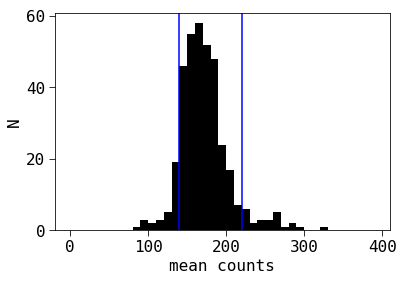

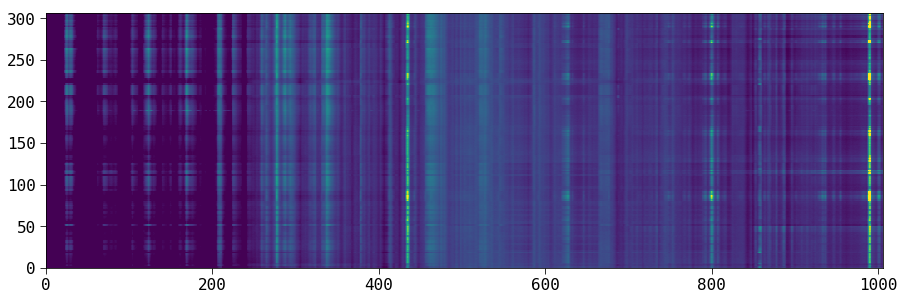

In [122]:
mm = np.mean( _XAcut[:,450:600], axis=1)

start, stop = 140., 220.
jj = (mm > start) * (mm < stop)
print("{} of {} survive cut.".format(np.sum(jj),len(jj)))
kk = jj
if True:
    plt.hist(mm,bins=np.arange(0,400,10))
    plt.axvline(start,c='b')
    plt.axvline(stop,c='b')
    plt.xlabel("mean counts")
    plt.ylabel("N")

    #% matplotlib notebook
    f = plt.figure(figsize=[15,15])
    #plt.imshow((XAcut.T/mm).T[jj*kk][:,275:300], vmin=.6,vmax=1.4, origin="bottom")
    plt.imshow((_XAcut.T/mm).T[jj], vmin=.6,vmax=2.4, origin="bottom")

XAcut = _XAcut[jj]

In [123]:
XAcut = _XAcut[jj*kk]
XBcut = _XBcut[jj*kk]

In [124]:
_XBcut.shape

(366, 112, 1006)

In [125]:
MA = np.mean(XAcut,axis=0)
XAmean = XAcut - MA

MB = np.mean(XBcut,axis=0)
XBmean = XBcut - MB

[9607.36134022 5707.15669031 3046.41355647 1230.50448816  630.72294077
  591.98518263  484.56160312  444.14930291  337.88130178  277.93731873
  261.38375159  221.39402246  177.00057179  161.56964003  124.95087661
  115.06608599  112.52665741   95.13175081   85.12512017   70.60554927
   65.7156603    65.39118382   60.82722831   56.0055228    53.89444903]


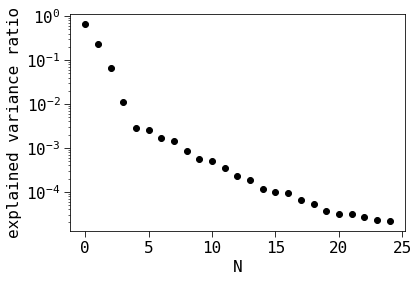

In [126]:
pcaA = PCA(n_components=n_components)
pcaA.fit(XAmean)
plt.plot(pcaA.explained_variance_ratio_, 'o')  
plt.xlabel("N")
plt.ylabel("explained variance ratio")
plt.yscale('log')
print(pcaA.singular_values_) 

In [127]:
# project pca componets onto
# mean shifted input spectra
ccA = np.inner(XAmean,pcaA.components_)

# reconstruct pca comonents through linear combination
rcA = np.matmul( XAmean.T, ccA).T
# they wont be normalized yet
for i,cA in enumerate(rcA):
    rcA[i] = rcA[i]/np.linalg.norm(rcA[i])

#rc = rc/np.linalg.norm(rc,axis=1)

In [128]:
# make sure the result is the same
(np.abs( rcA - pcaA.components_) < 1e-6).all()

False

In [129]:
# compute projection of input spectra onto PCA basis
tA = pcaA.transform(XAmean)

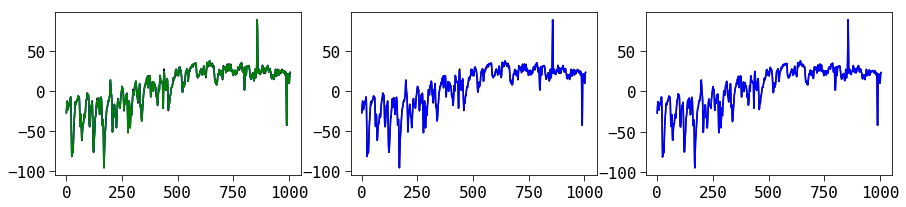

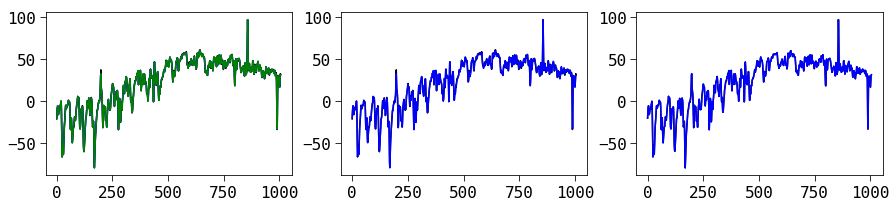

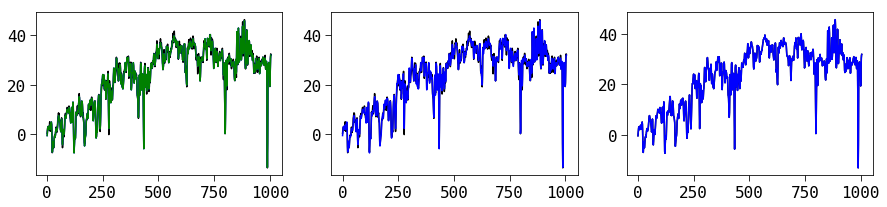

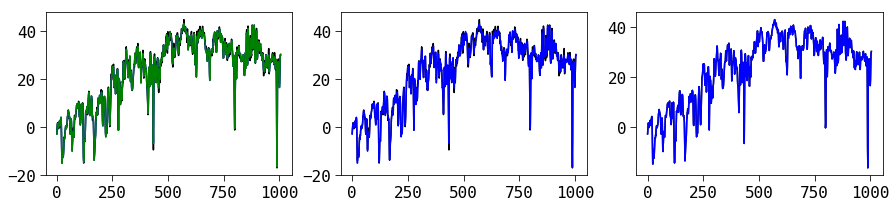

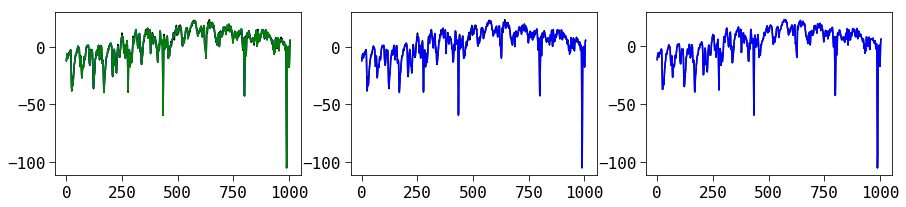

In [130]:
# make sure we can recontuct the spectra from the
# actual principal components but also from the reconstructed ones
for i in range(5):
    f = plt.figure(figsize=[15,3])
    plt.subplot(131)
    plt.plot( XAmean[i] )
    plt.plot( np.inner(tA, pcaA.components_.T)[i] )
    plt.plot( pcaA.inverse_transform(tA)[i] )


    plt.subplot(132)
    plt.plot( XAmean[i] )
    plt.plot( np.inner(tA, rcA.T)[i] )


    plt.subplot(133)
    plt.plot( np.inner(tA, pcaA.components_.T)[i] )
    plt.plot( np.inner(tA, rcA.T)[i] )


# Now apply this to B

In [131]:
# reconstruct pca components of B through linear combination of spectra from B
# BUT using projection from A
rcB = np.matmul( XBmean[:,fiber,:].T, ccA).T
# they wont be normalized yet
for i,cB in enumerate(rcB):
    rcB[i] = rcB[i]/np.linalg.norm(rcB[i])

In [132]:
# plot PCA components for A and B
if False:
    for i in range(pcaA.n_components):
        f = plt.figure(figsize=[15,2])
        plt.subplot(121)
        #plt.plot( XAmean[i] )
        plt.plot( pcaA.components_[i] )
        plt.subplot(122)
        #plt.plot( Xmean[i] )
        plt.plot( rcB[i] )    

/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


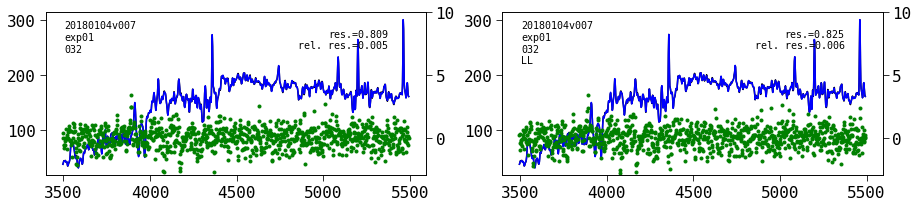

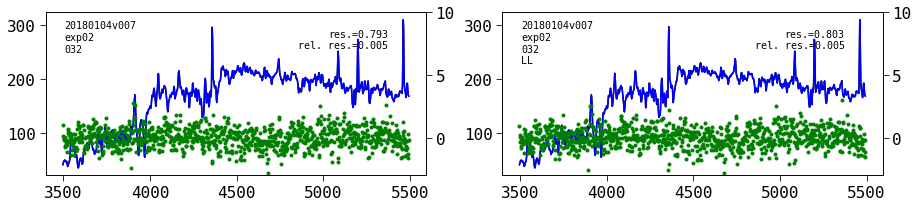

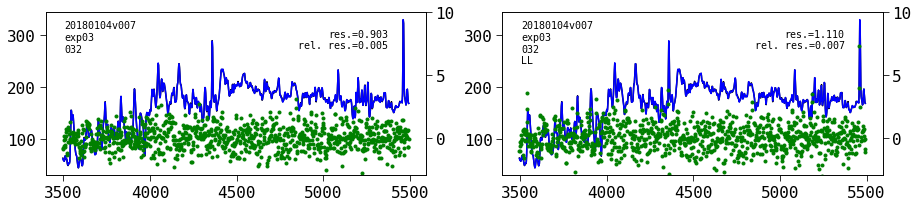

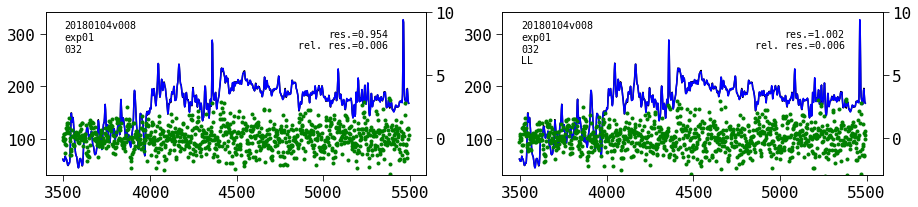

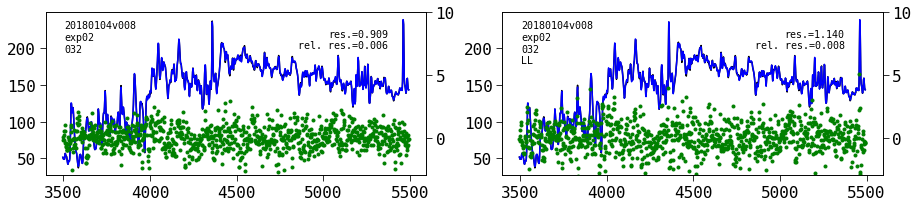

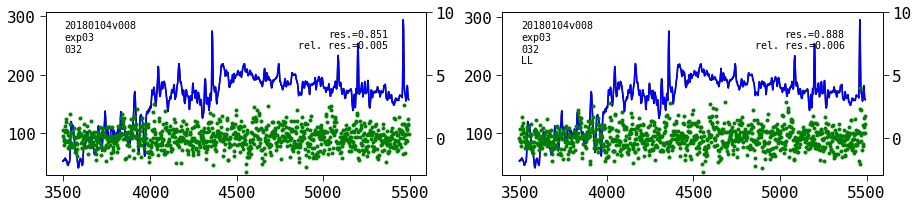

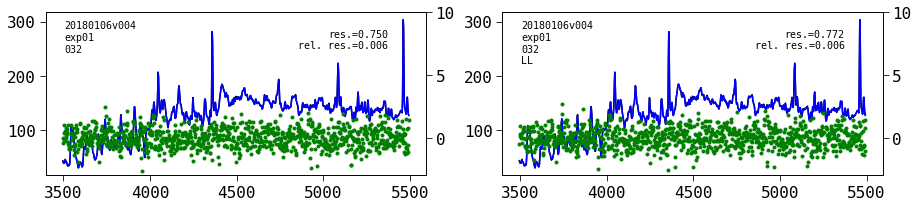

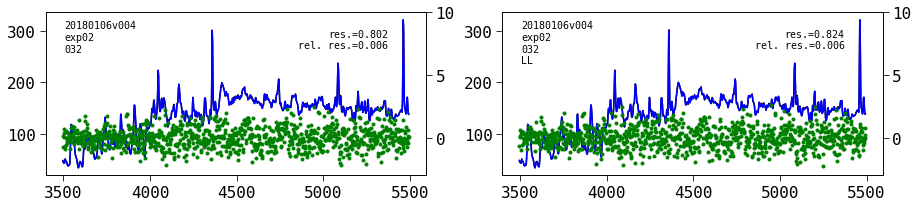

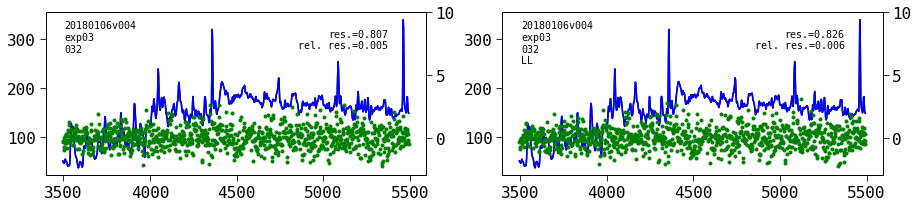

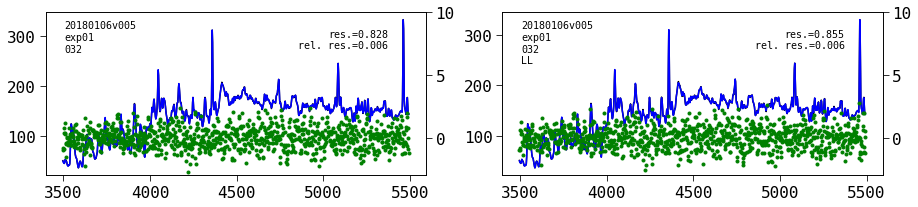

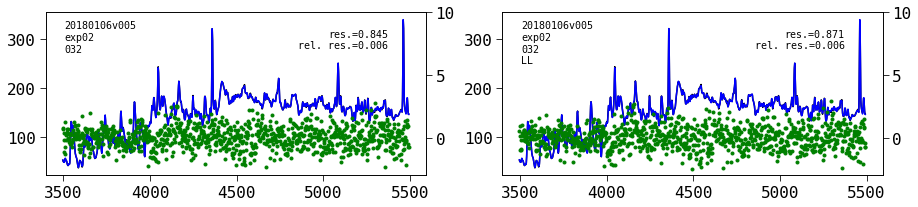

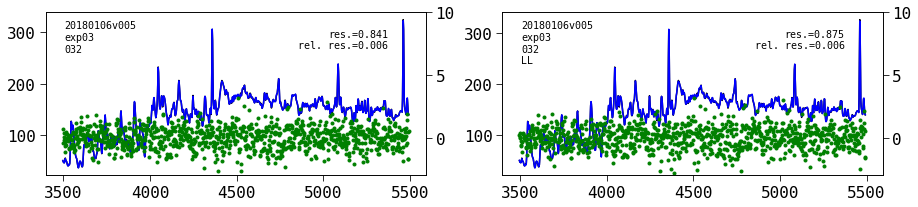

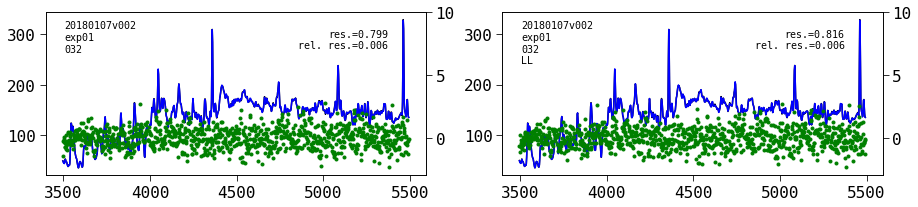

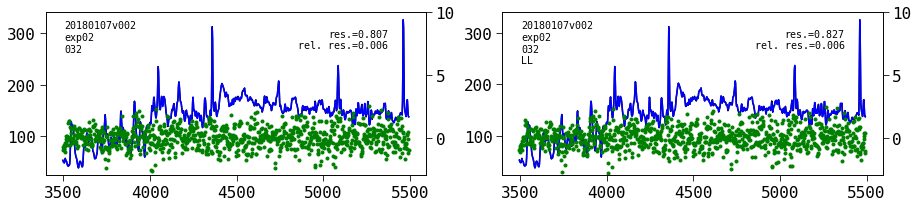

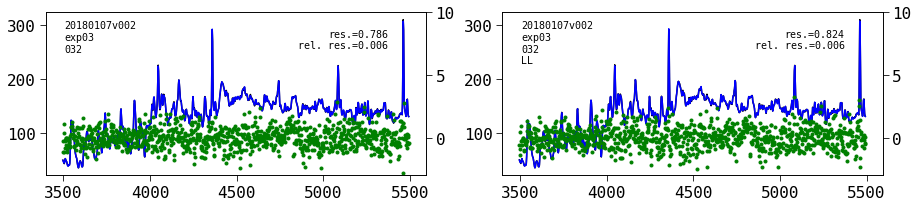

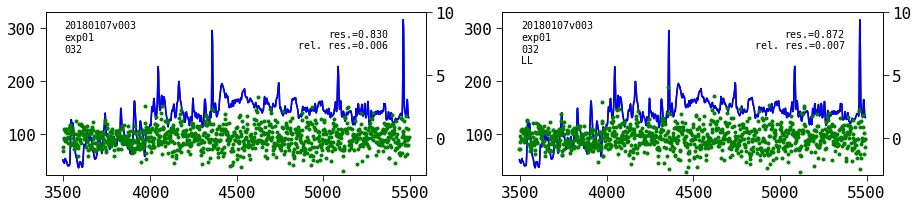

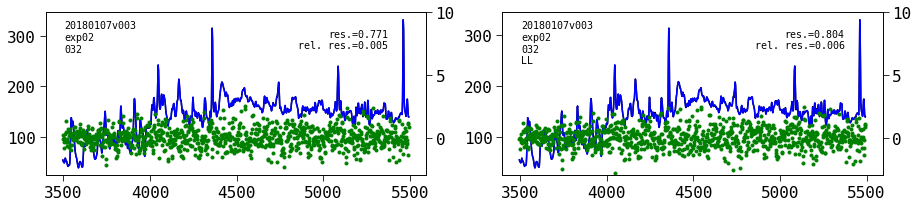

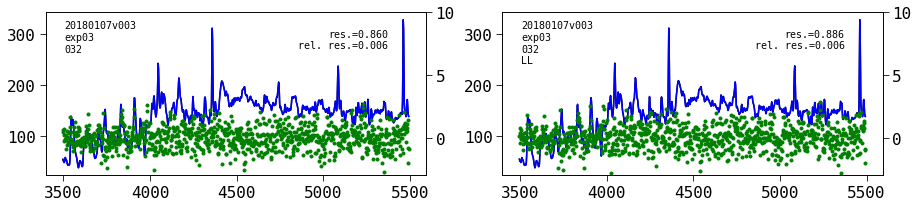

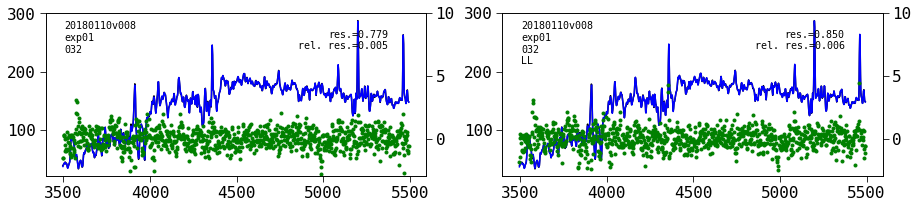

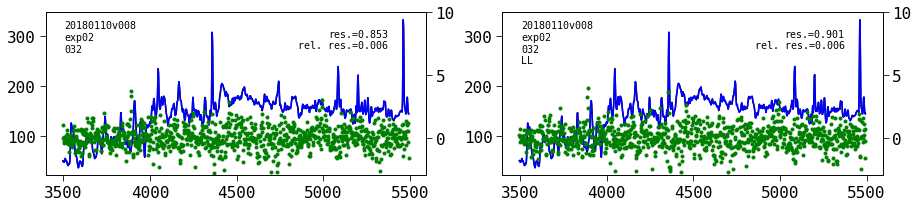

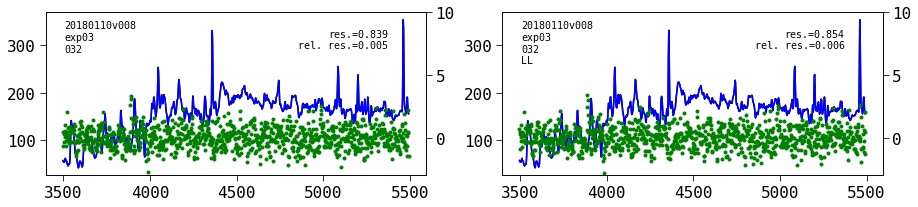

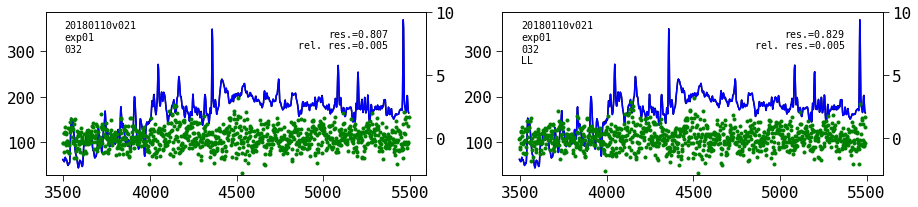

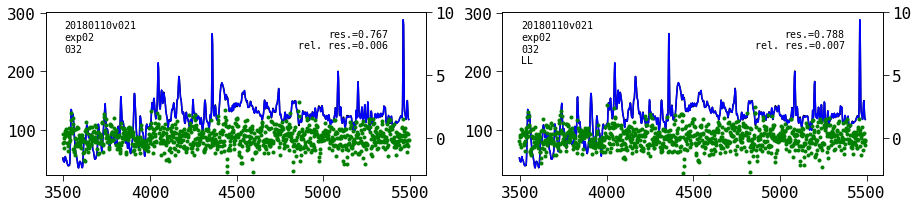

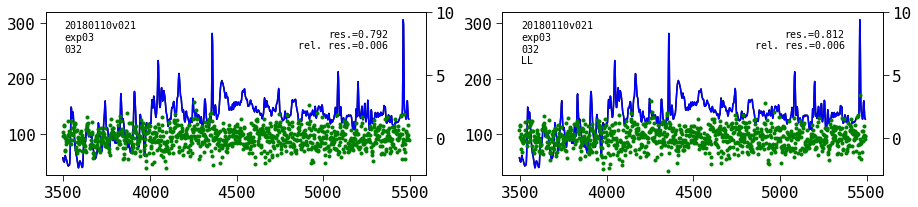

In [133]:
# Finally, chack how well we are doing:
# Make sure we can reconstuct the spectra from the
# actual principal components for A but also from the reconstructed ones for B
for i in range(24):
    f = plt.figure(figsize=[15,3])
    ax = plt.subplot(121)
    
    y  = XAmean[i] + MA
    ry = np.inner(tA, pcaA.components_.T)[i] + MA
    res = ry-y
    plt.plot(wwcut,  y )
    plt.plot(wwcut,   ry )
    plt.twinx()
    plt.plot(wwcut,   res, 'g.'  )
    plt.ylim([-3,10.])
    plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')
    
    plt.text(0.05,0.95,"{}\n{}\n{}".format(shotids[i][0], shotids[i][1], B[0],  fiber ), transform = ax.transAxes, ha='left',va='top')
    
    ax = plt.subplot(122, sharex=ax)
    
    y  = XBmean[i,fiber,:] + MB[fiber,:]
    ry = np.inner(tA, rcB.T)[i] + MB[fiber,:]
    res = ry-y
    
    plt.plot(wwcut,   y )
    plt.plot(wwcut,   ry )
    plt.twinx()
    
    plt.plot(wwcut,   res, 'g.' )
    plt.ylim([-3,10.])
    plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')
    
    plt.text(0.05,0.95,"{}\n{}\n{}\n{}".format(shotids[i][0], shotids[i][1], B[0],  B[1], fiber ), transform = ax.transAxes, ha='left',va='top')

In [83]:
B_recon_sky = np.zeros_like(XBmean)
i = 2 # select shot
for fiber in range(XBmean.shape[1]):
    #print(fiber)
    # reconstruct pca components of B through linear combination of spectra from B
    # BUT using projection from A
    rcB = np.matmul( XBmean[:,fiber,:].T, ccA).T
    # they wont be normalized yet
    for j,cB in enumerate(rcB):
        rcB[j] = rcB[j]/np.linalg.norm(rcB[j])

    ry = np.inner(tA, rcB.T)[i] + MB[fiber,:]
    B_recon_sky[i,fiber,:] = ry

    
    y  = XBmean[i,fiber,:] + MB[fiber,:]
    res = ry-y
    
    if False:
        f = plt.figure(figsize=[15,3])
        ax = plt.subplot(122, sharex=ax)
        plt.plot(wwcut,   y )
        plt.plot(wwcut,   ry )
        plt.twinx()

        plt.plot(wwcut,   res, 'g.' )
        plt.ylim([-1,10.])
        plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')

In [17]:
# Attempt for a faster version, does unfortunately NOT give the same results
if False:
    B_recon_skyNew = np.zeros_like(XBmean)
    i = 1 # select shot

    rcB = np.matmul( XBmean[:,:,:].T, ccA).T
    # they wont be normalized yet
    for j,cB in enumerate(rcB):
        rcB[j] = ( rcB[j].T/np.linalg.norm(rcB[j], axis=1) ).T

    ry = (np.inner(tA, rcB.T)[i].T + MB[fiber,:].T)
    B_recon_skyNew[i,:,:] = ry

    f=plt.figure()
    plt.imshow( B_recon_skyNew[i] )

    f=plt.figure()
    plt.imshow( B_recon_sky[i] )

    f=plt.figure()
    plt.imshow( B_recon_sky[i] - B_recon_skyNew[i] )

2


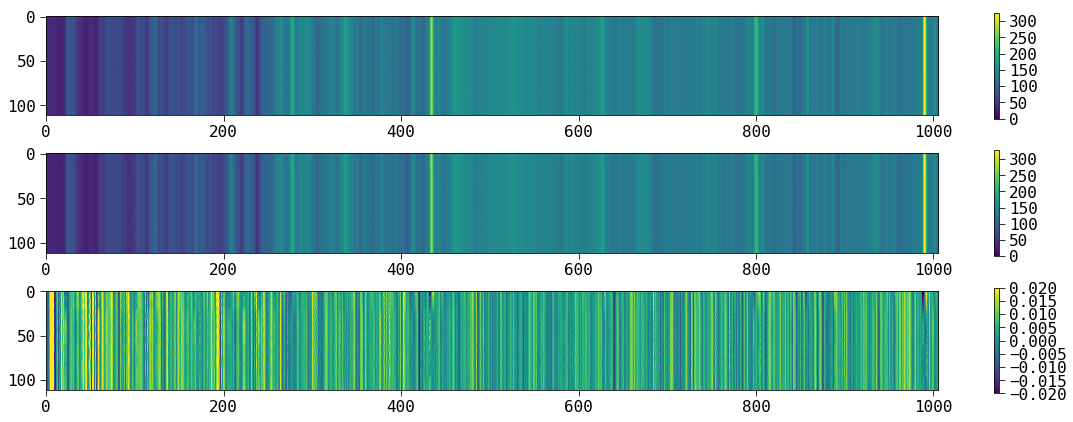

In [18]:
i = 2
f = plt.figure(figsize=[20,7])
ax1 = plt.subplot(311)
im = plt.imshow( B_recon_sky[i,:,:] )
cbar = f.colorbar(im)

ax1 = plt.subplot(312)
im = plt.imshow( XBmean[i,:,:] + MB[:,:]  )
cbar = f.colorbar(im)

ax1 = plt.subplot(313)
res = (B_recon_sky[i,:,:]  - (XBmean[i,:,:] + MB[:,:] ) )
#im = plt.imshow( res , vmin=-2., vmax=2.)
im = plt.imshow( res/MB[:,:] , vmin=-.02, vmax=.02)

cbar = f.colorbar(im)

print(i)

In [19]:

# Now do it for all nights
B_recon_sky = np.zeros_like(XBmean)

for i in range(XBmean.shape[0]):
    for fiber in range(XBmean.shape[1]):
        #print(fiber)
        # reconstruct pca components of B through linear combination of spectra from B
        # BUT using projection from A
        rcB = np.matmul( XBmean[:,fiber,:].T, ccA).T
        # they wont be normalized yet
        for j,cB in enumerate(rcB):
            rcB[j] = rcB[j]/np.linalg.norm(rcB[j])

        ry = np.inner(tA, rcB.T)[i] + MB[fiber,:]
        B_recon_sky[i,fiber,:] = ry


        y  = XBmean[i,fiber,:] + MB[fiber,:]
        res = ry-y
    
    

In [20]:
pca_skys = OrderedDict()
pca_skys[B] = OrderedDict()
for i,k in enumerate(shotids):
    #print(i,k)
    pca_skys[B][k] = B_recon_sky[i,:,:]

IndexError: index 356 is out of bounds for axis 0 with size 356

In [ ]:
import os
import glob

pattern="pca_test/rebin/{}/{}/multi_???_{}_???_{}_rebin.pickle"

def save_skys(B, pca_skys, pattern):
    IFU, amp = B
    
    skys = OrderedDict()
    shotids = []
    for k in pca_skys[B]:
        shotid, exp = k
    
        _pattern = pattern.format(shotid, exp, IFU, amp)
        ff = glob.glob(_pattern)
        if not len(ff) == 1:
            print("ERROR: Did not find files like {}".format(_pattern))
            return
        fname = ff[0]
        
        h,t = os.path.split(fname)
        pca_fname = os.path.join(h,"pca_" + t)
        
        
            
        ww,rb = pickle.load( open(fname,'rb'), encoding='iso-8859-1' )
        rb["fiber_to_fiber"] = rb["fiber_to_fiber"][:,:N]

        rb["pca_sky_spectrum"] = pca_skys[B][k] * rb["fiber_to_fiber"][:,ii] 
        
        pickle.dump(  ( ww,rb), open(pca_fname,'wb') , protocol=2   )
        print("Wrote ", pca_fname)
        
save_skys(B, pca_skys, pattern)

In [ ]:
pca_skys[(IFU, 'LL')][('20180124v010', 'exp01')]

In [ ]:
skys[(IFU, 'LL')][('20180124v010', 'exp01')]

In [ ]:
pca_sky =  pca_skys[(IFU, 'LL')][('20180124v010', 'exp01')] 
plt.imshow(pca_sky)

In [ ]:
original_sky = skys[(IFU, 'LL')][('20180124v010', 'exp01')][:,:N][:,ii]
plt.imshow( original_sky)

In [ ]:
plt.imshow(pca_sky - original_sky)